In [1]:
import sys
sys.path.append('../Deep-Learning-For-Remote-Sensing/torchgeo')
sys.path.append('../Deep-Learning-For-Computer-Vision-org/mmengine')
sys.path.append('../Deep-Learning-For-Computer-Vision-org/mmcv')
sys.path.append('../Deep-Learning-For-Computer-Vision-org/mmsegmentation')
sys.path.append('../Deep-Learning-For-Computer-Vision-org/mmdetection')

In [2]:
from aglw_l08_dataset import TrainDataloader, ValDataloader
import os
import tempfile
from urllib.parse import urlparse

import matplotlib.pyplot as plt
import planetary_computer
import pystac
import torch
from torch.utils.data import DataLoader

from torchgeo.datasets import RasterDataset, AbovegroundLiveWoodyBiomassDensity
from torchgeo.datasets.utils import download_url
from torchgeo.samplers import RandomGeoSampler, GridGeoSampler
from torchgeo.datasets.utils import BoundingBox

import numpy as np
from scipy.ndimage import zoom

In [3]:
import os

import torch
import matplotlib.pyplot as plt
#import pytorch_lightning as pl
from torch.optim import lr_scheduler
#import segmentation_models_pytorch as smp
from torch.utils.data import DataLoader

In [4]:
len(TrainDataloader), len(ValDataloader)

(1310, 99)

In [5]:
#np.histogram(sample['gt_sem_seg'][0],bins= range(13))

Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
/projects/Deep-Learning-For-Remote-Sensing/aglw_l08_dataset.py:112: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  res['data_samples'].gt_sem_seg = PixelData(data = torch.tensor(gt,dtype=torch.int64))
/projects/Deep-Learning-For-Remote-Sensing/../Deep-Learning-For-Computer-Vision-org/mmengine/mmengine/structures/pixel_data.py:83: UserWarning: The shape of value will convert from torch.Size([64, 64]) to torch.Size([1, 64, 64])
  warnings.warn('The shape of value will convert from '
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirect

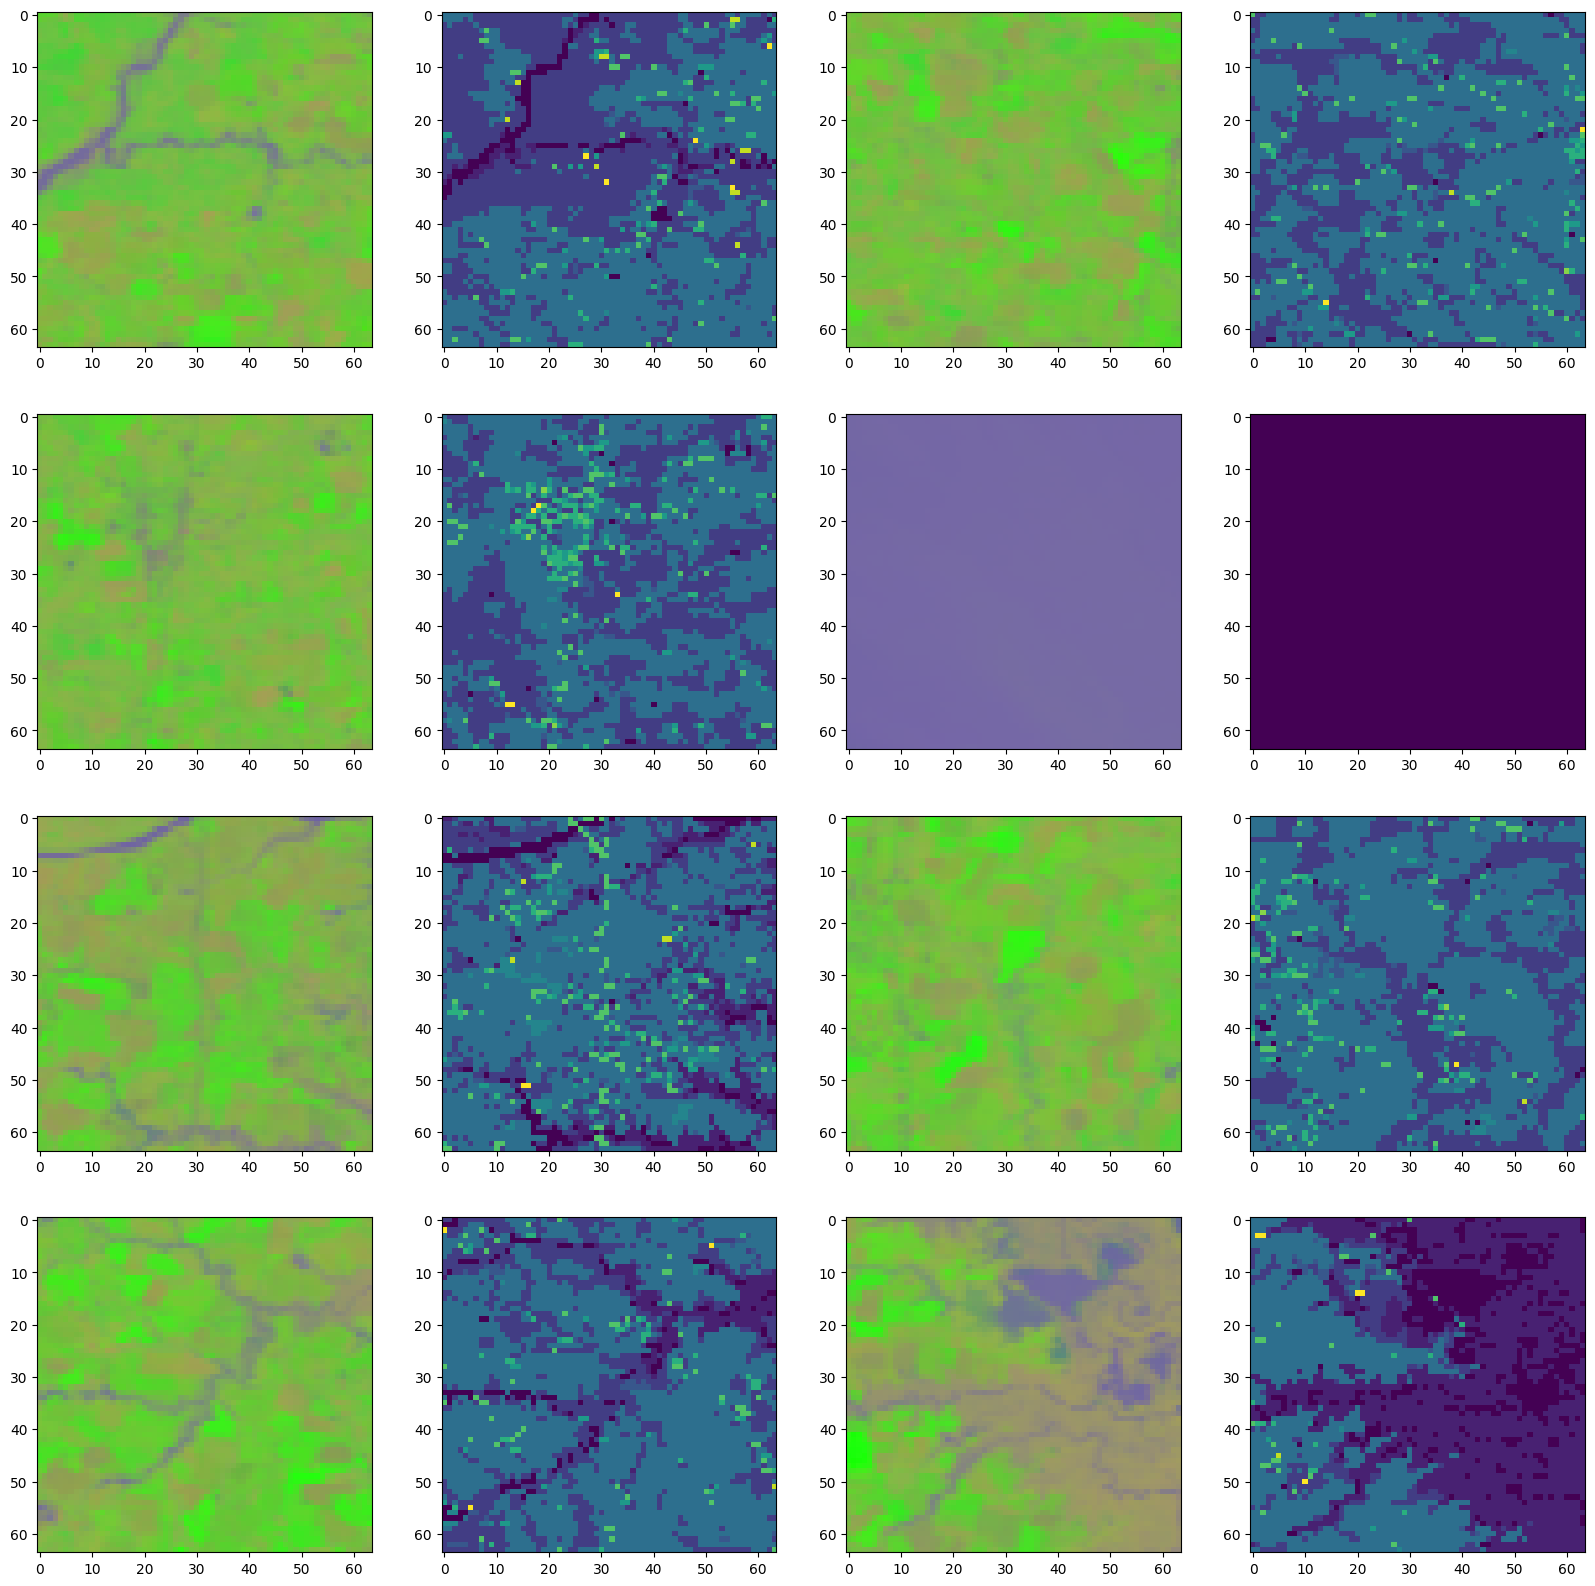

In [6]:
fig, axes = plt.subplots(nrows=4,ncols=4,figsize=(20,20))
axes      = axes.reshape(-1)
j = 0
for i,sample in enumerate(ValDataloader):
    axes[j].imshow(sample['inputs'][0].permute(1,2,0))
    axes[j+1].imshow(sample['gt_sem_seg'][0])
    j+=2
    if j == 16:
        break

In [7]:
# Copyright (c) OpenMMLab. All rights reserved.
import argparse
import logging
import os
import os.path as osp

from mmengine.config import Config, DictAction
from mmengine.logging import print_log
from mmengine.runner import Runner

from mmseg.registry import RUNNERS


def parse_args():
    parser = argparse.ArgumentParser(description='Train a segmentor')
    parser.add_argument('-f')
    #parser.add_argument('config', help='train config file path')
    parser.add_argument('--work-dir', help='the dir to save logs and models')
    parser.add_argument(
        '--resume',
        action='store_true',
        default=False,
        help='resume from the latest checkpoint in the work_dir automatically')
    parser.add_argument(
        '--amp',
        action='store_true',
        default=False,
        help='enable automatic-mixed-precision training')
    parser.add_argument(
        '--cfg-options',
        nargs='+',
        action=DictAction,
        help='override some settings in the used config, the key-value pair '
        'in xxx=yyy format will be merged into config file. If the value to '
        'be overwritten is a list, it should be like key="[a,b]" or key=a,b '
        'It also allows nested list/tuple values, e.g. key="[(a,b),(c,d)]" '
        'Note that the quotation marks are necessary and that no white space '
        'is allowed.')
    parser.add_argument(
        '--launcher',
        choices=['none', 'pytorch', 'slurm', 'mpi'],
        default='none',
        help='job launcher')
    # When using PyTorch version >= 2.0.0, the `torch.distributed.launch`
    # will pass the `--local-rank` parameter to `tools/train.py` instead
    # of `--local_rank`.
    parser.add_argument('--local_rank', '--local-rank', type=int, default=0)
    args = parser.parse_args()
    if 'LOCAL_RANK' not in os.environ:
        os.environ['LOCAL_RANK'] = str(args.local_rank)

    return args


args = parse_args()
args.config = '../Deep-Learning-For-Computer-Vision-org/mmsegmentation/configs/deeplabv3plus/deeplabv3plus_r50-d8_4xb2-40k_cityscapes-769x769.py'

# load config
cfg = Config.fromfile(args.config)

cfg.launcher = args.launcher
if args.cfg_options is not None:
    cfg.merge_from_dict(args.cfg_options)

# work_dir is determined in this priority: CLI > segment in file > filename
if args.work_dir is not None:
    # update configs according to CLI args if args.work_dir is not None
    cfg.work_dir = args.work_dir
elif cfg.get('work_dir', None) is None:
    # use config filename as default work_dir if cfg.work_dir is None
    cfg.work_dir = osp.join('./work_dirs',
                            osp.splitext(osp.basename(args.config))[0])

# enable automatic-mixed-precision training
if args.amp is True:
    optim_wrapper = cfg.optim_wrapper.type
    if optim_wrapper == 'AmpOptimWrapper':
        print_log(
            'AMP training is already enabled in your config.',
            logger='current',
            level=logging.WARNING)
    else:
        assert optim_wrapper == 'OptimWrapper', (
            '`--amp` is only supported when the optimizer wrapper type is '
            f'`OptimWrapper` but got {optim_wrapper}.')
        cfg.optim_wrapper.type = 'AmpOptimWrapper'
        cfg.optim_wrapper.loss_scale = 'dynamic'

# resume training
cfg.resume = args.resume
'''
# build the runner from config
if 'runner_type' not in cfg:
    # build the default runner
    runner = Runner.from_cfg(cfg)
else:
    # build customized runner from the registry
    # if 'runner_type' is set in the cfg
    runner = RUNNERS.build(cfg)
'''


"\n# build the runner from config\nif 'runner_type' not in cfg:\n    # build the default runner\n    runner = Runner.from_cfg(cfg)\nelse:\n    # build customized runner from the registry\n    # if 'runner_type' is set in the cfg\n    runner = RUNNERS.build(cfg)\n"

In [8]:
cfg.optim_wrapper.optimizer.lr = 0.01

In [9]:
from mmseg.registry import MODELS, EVALUATOR
from mmseg.utils import register_all_modules
#from mmdet.utils import register_all_modules as mmengine_register_all_modules
#mmengine_register_all_modules()
register_all_modules()
cfg.train_cfg['max_iters']    = 5000
cfg.train_cfg['val_interval'] = 250
cfg.model.data_preprocessor['mean'] = [0.5, 0.5, 0.5]
cfg.model.data_preprocessor['std']  = [1.0, 1.0, 1.0]
cfg.model.data_preprocessor['size'] = (64,64)
#cfg.model.decode_head.loss_decode = {'type' : 'MSELoss'}#, 'use_sigmoid' : False}
#cfg.model.auxiliary_head.loss_decode = {'type' : 'MSELoss'}#, 'loss_weight' : 0.4}#, 'use_sigmoid' : False}
cfg.model.decode_head.num_classes    = 13#5
cfg.model.auxiliary_head.num_classes = 13#5
model = MODELS.build(cfg.model)


#val_evaluator = EVALUATOR.build(cfg.val_evaluator)

/projects/Deep-Learning-For-Remote-Sensing/../Deep-Learning-For-Computer-Vision-org/mmsegmentation/mmseg/models/backbones/resnet.py:431: UserWarning: DeprecationWarning: pretrained is a deprecated, please use "init_cfg" instead
  warnings.warn('DeprecationWarning: pretrained is a deprecated, '
/projects/Deep-Learning-For-Remote-Sensing/../Deep-Learning-For-Computer-Vision-org/mmsegmentation/mmseg/models/losses/cross_entropy_loss.py:258: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


In [10]:
#cfg.model

In [11]:
from mmseg.evaluation import IoUMetric

In [12]:
cfg.val_evaluator

{'type': 'IoUMetric', 'iou_metrics': ['mIoU']}

In [13]:
val_evaluator = IoUMetric(ignore_index = 0, iou_metrics = ['mIoU'], output_dir= 'work_dir')

09/28 16:46:48 - mmengine - WARNING - The prefix is not set in metric class IoUMetric.


In [14]:
#val_evaluator = EVALUATOR.build(cfg.val_evaluator)

In [15]:
#from mmdet.registry import EVALUATOR, METRICS

In [16]:
mdl = torch.load('weights/deeplabv3plus_r50-d8_769x769_80k_cityscapes_20200606_210233-0e9dfdc4.pth')['state_dict']
ignore_keys = ['decode_head.conv_seg.weight', 'auxiliary_head.conv_seg.weight','decode_head.conv_seg.bias','auxiliary_head.conv_seg.bias']
new_mdl = {}
for key in mdl.keys():
    if key not in ignore_keys:
        new_mdl[key] = mdl[key]
model.load_state_dict(new_mdl,strict = False)

_IncompatibleKeys(missing_keys=['decode_head.conv_seg.weight', 'decode_head.conv_seg.bias', 'auxiliary_head.conv_seg.weight', 'auxiliary_head.conv_seg.bias'], unexpected_keys=[])

In [17]:
runner = Runner(model = model,
                train_dataloader = TrainDataloader,
                val_dataloader   = ValDataloader,
                #test_dataloader  = NDVIDataloader,
                train_cfg        = cfg.train_cfg,
                optim_wrapper    = cfg.optim_wrapper,
                val_cfg          = cfg.val_cfg,
                val_evaluator    = val_evaluator,
                work_dir         = 'work_dir')

09/28 16:46:48 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.10.12 (main, Jul 29 2024, 16:56:48) [GCC 11.4.0]
    CUDA available: True
    MUSA available: False
    numpy_random_seed: 156606063
    GPU 0: NVIDIA GeForce GTX 1660 Ti
    CUDA_HOME: /usr/local/cuda
    NVCC: Cuda compilation tools, release 12.1, V12.1.105
    GCC: x86_64-linux-gnu-gcc (Ubuntu 11.4.0-1ubuntu1~22.04) 11.4.0
    PyTorch: 2.1.0+cu121
    PyTorch compiling details: PyTorch built with:
  - GCC 9.3
  - C++ Version: 201703
  - Intel(R) oneAPI Math Kernel Library Version 2022.2-Product Build 20220804 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v3.1.1 (Git Hash 64f6bcbcbab628e96f33a62c3e975f8535a7bde4)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX2
  - CUDA Runtime 12.1
  - NVCC architecture flags: -gencode;arch=c

In [18]:
# start training
# loops val_loop evaluator.evaluate(len(dataloader))
runner.train()

09/28 16:46:48 - mmengine - WARNING - Dataset NDVIDataset has no metainfo. ``dataset_meta`` in visualizer will be None.
09/28 16:46:48 - mmengine - WARNING - Dataset NDVIDataset has no metainfo. ``dataset_meta`` in evaluator, metric and visualizer will be None.
09/28 16:46:48 - mmengine - INFO - load model from: open-mmlab://resnet50_v1c
09/28 16:46:48 - mmengine - INFO - Loads checkpoint by openmmlab backend from path: open-mmlab://resnet50_v1c
09/28 16:46:49 - mmengine - WARNING - The model and loaded state dict do not match exactly

unexpected key in source state_dict: fc.weight, fc.bias

09/28 16:46:49 - mmengine - WARNING - "FileClient" will be deprecated in future. Please use io functions in https://mmengine.readthedocs.io/en/latest/api/fileio.html#file-io
09/28 16:46:49 - mmengine - WARNING - "HardDiskBackend" is the alias of "LocalBackend" and the former will be deprecated in future.
09/28 16:46:49 - mmengine - INFO - Checkpoints will be saved to /projects/Deep-Learning-For-Rem

/projects/Deep-Learning-For-Remote-Sensing/aglw_l08_dataset.py:112: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  res['data_samples'].gt_sem_seg = PixelData(data = torch.tensor(gt,dtype=torch.int64))
/projects/Deep-Learning-For-Remote-Sensing/../Deep-Learning-For-Computer-Vision-org/mmengine/mmengine/structures/pixel_data.py:83: UserWarning: The shape of value will convert from torch.Size([64, 64]) to torch.Size([1, 64, 64])
  warnings.warn('The shape of value will convert from '
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirect

09/28 16:47:02 - mmengine - INFO - Epoch(train) [1][  10/1310]  lr: 1.0000e-02  eta: 1:52:28  time: 1.3524  data_time: 0.8099  memory: 947  loss: 2.8055  decode.loss_ce: 1.9003  decode.acc_seg: 64.6591  aux.loss_ce: 0.9052  aux.acc_seg: 64.6591


Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


09/28 16:47:12 - mmengine - INFO - Epoch(train) [1][  20/1310]  lr: 1.0000e-02  eta: 1:38:55  time: 1.0314  data_time: 0.5443  memory: 947  loss: 1.5594  decode.loss_ce: 1.0100  decode.acc_seg: 64.7430  aux.loss_ce: 0.5494  aux.acc_seg: 64.7430


Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


09/28 16:47:22 - mmengine - INFO - Epoch(train) [1][  30/1310]  lr: 1.0000e-02  eta: 1:32:47  time: 0.9768  data_time: 0.4891  memory: 947  loss: 1.3023  decode.loss_ce: 0.8857  decode.acc_seg: 64.3585  aux.loss_ce: 0.4166  aux.acc_seg: 66.3254
09/28 16:47:31 - mmengine - INFO - Epoch(train) [1][  40/1310]  lr: 1.0000e-02  eta: 1:26:57  time: 0.8472  data_time: 0.3597  memory: 947  loss: 1.2784  decode.loss_ce: 0.9000  decode.acc_seg: 61.1496  aux.loss_ce: 0.3784  aux.acc_seg: 61.3495
09/28 16:47:40 - mmengine - INFO - Epoch(train) [1][  50/1310]  lr: 1.0000e-02  eta: 1:25:26  time: 0.9708  data_time: 0.4825  memory: 947  loss: 1.1883  decode.loss_ce: 0.8438  decode.acc_seg: 68.6172  aux.loss_ce: 0.3445  aux.acc_seg: 68.5196
09/28 16:47:49 - mmengine - INFO - Epoch(train) [1][  60/1310]  lr: 1.0000e-02  eta: 1:23:05  time: 0.8762  data_time: 0.3882  memory: 947  loss: 1.2074  decode.loss_ce: 0.8572  decode.acc_seg: 65.0772  aux.loss_ce: 0.3502  aux.acc_seg: 62.2604
09/28 16:47:58 - mme

Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


09/28 16:48:07 - mmengine - INFO - Epoch(train) [1][  80/1310]  lr: 1.0000e-02  eta: 1:20:28  time: 0.8999  data_time: 0.4118  memory: 947  loss: 1.1834  decode.loss_ce: 0.8425  decode.acc_seg: 65.3625  aux.loss_ce: 0.3410  aux.acc_seg: 65.2130


Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


09/28 16:48:16 - mmengine - INFO - Epoch(train) [1][  90/1310]  lr: 1.0000e-02  eta: 1:19:35  time: 0.9024  data_time: 0.4138  memory: 947  loss: 1.1466  decode.loss_ce: 0.8165  decode.acc_seg: 64.3112  aux.loss_ce: 0.3301  aux.acc_seg: 64.8560
09/28 16:48:27 - mmengine - INFO - Epoch(train) [1][ 100/1310]  lr: 1.0000e-02  eta: 1:20:13  time: 1.0698  data_time: 0.5806  memory: 947  loss: 1.1297  decode.loss_ce: 0.8031  decode.acc_seg: 72.3465  aux.loss_ce: 0.3266  aux.acc_seg: 69.3832
09/28 16:48:36 - mmengine - INFO - Epoch(train) [1][ 110/1310]  lr: 1.0000e-02  eta: 1:19:54  time: 0.9616  data_time: 0.4735  memory: 947  loss: 1.1403  decode.loss_ce: 0.8102  decode.acc_seg: 57.9773  aux.loss_ce: 0.3301  aux.acc_seg: 57.8720
09/28 16:48:46 - mmengine - INFO - Epoch(train) [1][ 120/1310]  lr: 1.0000e-02  eta: 1:19:19  time: 0.9189  data_time: 0.4308  memory: 947  loss: 1.1489  decode.loss_ce: 0.8153  decode.acc_seg: 67.4286  aux.loss_ce: 0.3336  aux.acc_seg: 69.0552
09/28 16:48:55 - mme

NameError: name 'cv2' is not defined

In [ ]:
for idx, data_batch in enumerate(ValDataloader):
    print(idx)

In [ ]:
len(TrainDataloader.dataset)

In [ ]:
cfg.train_cfg['max_iters']

In [ ]:
model.eval()
res = model(sample['inputs'][0][None])#.to('cuda'))

In [ ]:
plt.plot(sample['gt_sem_seg'][0].reshape(-1))

In [ ]:
plt.imshow(sample['gt_sem_seg'][0])
plt.show()

In [ ]:
res[0].argmax(axis=0)

In [ ]:
plt.imshow(res[0].argmax(axis=0).detach().cpu().numpy())

In [ ]:
plt.imshow(res[0][4].detach().cpu().numpy())

In [ ]:
#.data.detach().cpu().numpy().shape

In [ ]:
plt.imshow(res[0].pred_sem_seg.data[0].detach().cpu().numpy())

In [ ]:
class PetModel(pl.LightningModule):
    def __init__(self, arch, encoder_name, in_channels, out_classes, **kwargs):
        super().__init__()
        self.model = smp.create_model(
            arch,
            encoder_name=encoder_name,
            in_channels=in_channels,
            classes=out_classes,
            **kwargs,
        )
        # preprocessing parameteres for image
        params = smp.encoders.get_preprocessing_params(encoder_name)
        self.register_buffer("std", torch.tensor(params["std"]).view(1, 3, 1, 1))
        self.register_buffer("mean", torch.tensor(params["mean"]).view(1, 3, 1, 1))

        # for image segmentation dice loss could be the best first choice
        self.loss_fn = smp.losses.DiceLoss(smp.losses.BINARY_MODE, from_logits=True)

        # initialize step metics
        self.training_step_outputs = []
        self.validation_step_outputs = []
        self.test_step_outputs = []

    def forward(self, image):
        # normalize image here
        image = (image - self.mean) / self.std
        mask = self.model(image)
        return mask

    def shared_step(self, batch, stage):
        image = batch["image"]

        # Shape of the image should be (batch_size, num_channels, height, width)
        # if you work with grayscale images, expand channels dim to have [batch_size, 1, height, width]
        assert image.ndim == 4

        # Check that image dimensions are divisible by 32,
        # encoder and decoder connected by `skip connections` and usually encoder have 5 stages of
        # downsampling by factor 2 (2 ^ 5 = 32); e.g. if we have image with shape 65x65 we will have
        # following shapes of features in encoder and decoder: 84, 42, 21, 10, 5 -> 5, 10, 20, 40, 80
        # and we will get an error trying to concat these features
        h, w = image.shape[2:]
        assert h % 32 == 0 and w % 32 == 0

        mask = batch["mask"]
        assert mask.ndim == 4

        # Check that mask values in between 0 and 1, NOT 0 and 255 for binary segmentation
        assert mask.max() <= 1.0 and mask.min() >= 0

        logits_mask = self.forward(image)

        # Predicted mask contains logits, and loss_fn param `from_logits` is set to True
        loss = self.loss_fn(logits_mask, mask)

        # Lets compute metrics for some threshold
        # first convert mask values to probabilities, then
        # apply thresholding
        prob_mask = logits_mask.sigmoid()
        pred_mask = (prob_mask > 0.5).float()

        # We will compute IoU metric by two ways
        #   1. dataset-wise
        #   2. image-wise
        # but for now we just compute true positive, false positive, false negative and
        # true negative 'pixels' for each image and class
        # these values will be aggregated in the end of an epoch
        tp, fp, fn, tn = smp.metrics.get_stats(
            pred_mask.long(), mask.long(), mode="binary"
        )
        return {
            "loss": loss,
            "tp": tp,
            "fp": fp,
            "fn": fn,
            "tn": tn,
        }

    def shared_epoch_end(self, outputs, stage):
        # aggregate step metics
        tp = torch.cat([x["tp"] for x in outputs])
        fp = torch.cat([x["fp"] for x in outputs])
        fn = torch.cat([x["fn"] for x in outputs])
        tn = torch.cat([x["tn"] for x in outputs])

        # per image IoU means that we first calculate IoU score for each image
        # and then compute mean over these scores
        per_image_iou = smp.metrics.iou_score(
            tp, fp, fn, tn, reduction="micro-imagewise"
        )

        # dataset IoU means that we aggregate intersection and union over whole dataset
        # and then compute IoU score. The difference between dataset_iou and per_image_iou scores
        # in this particular case will not be much, however for dataset
        # with "empty" images (images without target class) a large gap could be observed.
        # Empty images influence a lot on per_image_iou and much less on dataset_iou.
        dataset_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")
        metrics = {
            f"{stage}_per_image_iou": per_image_iou,
            f"{stage}_dataset_iou": dataset_iou,
        }

        self.log_dict(metrics, prog_bar=True)

    def training_step(self, batch, batch_idx):
        train_loss_info = self.shared_step(batch, "train")
        # append the metics of each step to the
        self.training_step_outputs.append(train_loss_info)
        return train_loss_info

    def on_train_epoch_end(self):
        self.shared_epoch_end(self.training_step_outputs, "train")
        # empty set output list
        self.training_step_outputs.clear()
        return

    def validation_step(self, batch, batch_idx):
        valid_loss_info = self.shared_step(batch, "valid")
        self.validation_step_outputs.append(valid_loss_info)
        return valid_loss_info

    def on_validation_epoch_end(self):
        self.shared_epoch_end(self.validation_step_outputs, "valid")
        self.validation_step_outputs.clear()
        return

    def test_step(self, batch, batch_idx):
        test_loss_info = self.shared_step(batch, "test")
        self.test_step_outputs.append(test_loss_info)
        return test_loss_info

    def on_test_epoch_end(self):
        self.shared_epoch_end(self.test_step_outputs, "test")
        # empty set output list
        self.test_step_outputs.clear()
        return

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=2e-4)
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=T_MAX, eta_min=1e-5)
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "interval": "step",
                "frequency": 1,
            },
        }
        return

In [ ]:
model = PetModel("FPN", "resnet34", in_channels=3, out_classes=1)

In [ ]:
#yapf
#addict
#termcolor
#ftfy
#regex
#prettytable

In [ ]:
# resume training
cfg.resume = args.resume
runner     = Runner.from_cfg(cfg)


# start training
#runner.train()

In [ ]:
type(runner.model)

In [ ]:
runner.set['train_dataloader'] = NDVIDataloader
#runner.train_dataloader = NDVIDataloader

In [ ]:
runner.model.loss()